In [6]:
%matplotlib nbagg
#from photodiag import PalmSetup
import photodiag
import json
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import h5py
import os, glob


from scipy.special import erf
from scipy.optimize import curve_fit
from alvra_tools import load_data
from IPython.display import clear_output

# First part: load a THz scan to calibrate the eV to fs slope

### First look for the correct PALM calibration file

In [7]:
DIRcalib = '/sf/photo/src/PALM/calib/'
#DIRcalib = '/sf/photo/src/PALM/calib/Alvra'

!ls -lah -rt $DIRcalib | grep palm_etof

-rw-rw-r--. 1 arrell_c unx-sf_photo 349K Mar  5  2019 2019-02-28_12:18:56.palm_etof
-rw-rw-r--. 1 arrell_c unx-sf_photo 223K May 24  2019 2019-05-24_13:40:42.palm_etof
-rw-rw-r--. 1 arrell_c unx-sf_photo 254K Mar 10 17:30 2020-03-10_16:26:51.palm_etof


### Now load the calibration file and give the energy range

In [8]:
CalibrationFn = DIRcalib + '2019-05-24_13:40:42.palm_etof'     # 12 keV settings

energyFrom =  2050
energyTo =    2320
energySteps = 2000

###########################################################################################

palm = photodiag.PalmSetup({'0': 'SAROP11-PALMK118:CH1_BUFFER', '1': 'SAROP11-PALMK118:CH2_BUFFER'},
                 noise_range=[0, 250],
                 energy_range=np.linspace(energyFrom, energyTo, energySteps))

palm.load_etof_calib(CalibrationFn)    

# define the fitfunction
def fitThz(x, a, b, c, d, e, f):
    return a + b*np.exp(-(c-x)**2/np.abs(d)**2)*np.sin(e*x + f) 


### Now choose the directory of the json file for the THz scan

In [14]:
DIRjson = "/sf/alvra/data/p18389/res/PhotoDiag/scan_info/"

!ls -lah -rt $DIRjson | grep json

-rw-r--r--. 1 39147 p18389  13K Mar 13 19:54 2020-03-13-spec_enc_calib_001_scan_info.json
-rw-r--r--. 1 39147 p18389  13K Mar 13 20:04 2020-03-13-spec_enc_calib_002_scan_info.json
-rw-r--r--. 1 39147 p18389  13K Mar 14 18:07 2020-03-14-palm_calib_001_scan_info.json
-rw-r--r--. 1 39147 p18389  13K Mar 15 06:37 2020-03-14-palm_calib_002_scan_info.json
-rw-r--r--. 1 39147 p18389 7.7K Mar 15 06:47 2020-03-15-palm_calib_003_scan_info.json
-rw-r--r--. 1 39147 p18389 7.7K Mar 15 06:56 2020-03-15-palm_calib_004_scan_info.json
-rw-r--r--. 1 39147 p18389 7.7K Mar 15 07:56 2020-03-15-palm_calib_005_scan_info.json
-rw-r--r--. 1 39147 p18389 7.7K Mar 15 08:18 2020-03-15-palm_calib_006_scan_info.json
-rw-r--r--. 1 39147 p18389    0 Mar 16 07:50 2020-03-16-palm_calib_007_scan_info.json


 ### Load the THz scan

In [17]:
scan_name = '2020-03-16-palm_calib_007'

###########################################

fn_json = DIRjson + scan_name + '_scan_info.json'

with open(fn_json) as f:
    dataFiles = json.load(f)
numFiles = len(dataFiles['scan_files'])
StagePOS = dataFiles['scan_values'][:]

eVIntP = []
eVIntUp = []
wf_str = []
wf_ref = []

for i in range(0,numFiles):
    fn = str(dataFiles['scan_files'][i][0])
    with h5py.File(fn, 'r') as fileName:
        fileName = load_data._get_data(fileName)
                
        ### Use the following lines will work if there is TIFALL5 in the channel list
        EventCode = fileName['SAR-CVME-TIFALL5:EvtSet/data']
        FEL = EventCode[:,48]
        Laser = EventCode[:,18]
        Darkshot = EventCode[:,21]
        index_ok = np.logical_and.reduce((FEL, Laser, np.logical_not(Darkshot)))
        
        ### Use the following line if there is no TIFALL5, need to know the FEL/laser reprate however...
        #index_ok = PulseIds%2 == 0 
                
        TOF = -fileName['SAROP11-PALMK118:CH2_BUFFER/data'][:]
        uTOF = -fileName['SAROP11-PALMK118:CH1_BUFFER/data'][:]
        PulseIds = fileName['SAROP11-PALMK118:CH2_BUFFER/pulse_id'][:]        
                
        tmpP = palm.etofs['1'].convert(input_data=TOF[index_ok], interp_energy=palm.energy_range)
        tmpUp = palm.etofs['0'].convert(input_data=uTOF[index_ok],interp_energy=palm.energy_range)
        
    
        eVIntP.append(tmpP)
        eVIntUp.append(tmpUp)
        wf_str.append(TOF[index_ok])
        wf_ref.append(uTOF[index_ok])
        clear_output(wait=True)
        print('Loaded file %s' %str(dataFiles['scan_files'][i][0]))


eVIntP = np.array(eVIntP)
eVIntUp = np.array(eVIntUp)

wf_str = np.array(wf_str)
wf_ref = np.array(wf_ref)
StagePOS = np.array(StagePOS)
Stagefs = (StagePOS[:,0]*1e-3*2/3e8)*1e15

Datasize = str(wf_str.shape)
print('Datasize = {}'.format(Datasize))

Loaded file /sf/alvra/data/p18389/res/PhotoDiag/scan_data/2020-03-16-palm_calib_007_step0030.h5
Datasize = (31, 125, 2000)


t0 is at 7.049724436675161e-10 s
Max streak is 150.06003001500721 eV
t0 from phase is at 7.05159202479426e-10 s
Calibration factor is -3.530154205676321 eV/fs
201922.21442700588


<IPython.core.display.Javascript object>


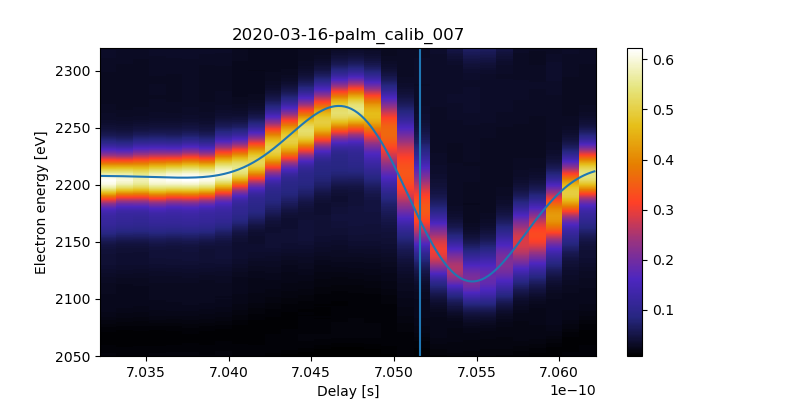

Scan 2020-03-16-palm_calib_007, t0 from phase = 7.05159202479426e-10 and peak-to-peak streak of 153.87 eV


In [18]:
### Load is done, now run this cell to calculate the calibration factor (eV2)

# determining t0 and peak-to-peak distance
streak=np.transpose(np.array([StagePOS[:,0], palm.energy_range[np.argmax(np.transpose(eVIntP.mean(axis=1)),axis =0)]]))
streakDerivative=np.transpose(np.array([[np.mean(t) for t in np.transpose([streak[:-1,0],streak[1:,0]])],np.diff(streak[:,1])/np.diff(streak[:,0])]))
#streakDerivative=np.transpose(np.array([streak[:-1,0],np.diff(streak[:,1])/np.diff(streak[:,0])]))
t0=[t[0] for t in streakDerivative if t[1]==min(streakDerivative[:,1])][0]

print("t0 is at {} s".format(t0))
print("Max streak is {} eV".format(max(np.array([t for t in streak if t[0]<t0])[:,1])-min(np.array([t for t in streak if t[0]>t0])[:,1])))

#Now fit with fit function
param_bounds = ([300,10,5.4e-10,1e-13,2e12,0],[600,500,5.5e-10,3e-12,4e12,np.inf])
parameters,extras = curve_fit(fitThz,StagePOS[:,0],palm.energy_range[np.argmax(np.transpose(eVIntP.mean(axis=1)),axis =0)], 
                              p0 = [np.min(palm.energy_range), 50, t0,2e-12,2.8e12,1])#,bounds=param_bounds)
# make the derivative 
dx = StagePOS[2,0]-StagePOS[1,0]
d_fitTHz_dx = np.gradient(fitThz(StagePOS[:,0],*parameters), dx)

max_y = np.max(np.gradient(fitThz(StagePOS[:,0],*parameters)))  # Find the maximum y value
max_x = np.argmin(np.gradient(fitThz(StagePOS[:,0],*parameters)))  # Find the maximum y value

# t0 from the phase fit 
t0_from_phase = parameters[2] + (parameters[4]*parameters[5])**-1 

calibrationLineSlope=np.interp(t0_from_phase,StagePOS[:,0],d_fitTHz_dx)
calibrationLineIntercept=np.interp(t0_from_phase,StagePOS[:,0],fitThz(StagePOS[:,0],*parameters))-calibrationLineSlope*t0_from_phase
ev2fsCalib = 1/(calibrationLineSlope*1e-15)
#print(max_x, max_y)
print ("t0 from phase is at {} s".format(t0_from_phase))
print ("Calibration factor is {} eV/fs".format(ev2fsCalib))
#print(parameters[2])
#print([calibrationLineSlope,calibrationLineIntercept,t0_from_phase])
print (calibrationLineIntercept)
# Trace from fit
xS=np.arange(np.min(StagePOS[:,0]),np.max(StagePOS[:,0]),(np.max(StagePOS[:,0])-np.min(StagePOS[:,0]))/300)
ySFitted=[fitThz(x, parameters[0],parameters[1],parameters[2],parameters[3],parameters[4],parameters[5]) for x in xS]

# Trace line 
#Trace_lin_fit = calibrationLineSlope * 


# Plot
fig = plt.figure(figsize=(8,4))
plt.pcolormesh(StagePOS[:,0], palm.energy_range, np.transpose(eVIntP.mean(axis=1)), cmap='CMRmap')
plt.colorbar()
plt.plot(xS,ySFitted)
plt.axvline(t0_from_phase)
plt.xlabel('Delay [s]')
plt.ylabel('Electron energy [eV]')
plt.title(scan_name)
plt.show()
PeakToPeak = np.max(ySFitted)-np.min(ySFitted)
print('Scan {}, t0 from phase = {} and peak-to-peak streak of {} eV'.format(scan_name, t0_from_phase, np.round(PeakToPeak,2)))

In [10]:
DIR = "/sf/alvra/data/p18389/raw/TD1_30ps_pump_dark/"

!ls -lah -rt $DIR | grep BSREAD

!hostname

listfile = os.listdir(DIR)
number_files = len(listfile)
print ("There are",number_files / 2," BSREAD files in the folder", DIR)

-rw-r--r--.  1 root p18389 1.5G Mar 15 00:08 run_000553.BSREAD.h5
-rw-r--r--.  1 root p18389 1.5G Mar 15 00:10 run_000554.BSREAD.h5
-rw-r--r--.  1 root p18389 1.5G Mar 15 00:12 run_000555.BSREAD.h5
-rw-r--r--.  1 root p18389 1.5G Mar 15 00:13 run_000556.BSREAD.h5
-rw-r--r--.  1 root p18389 1.5G Mar 15 00:15 run_000557.BSREAD.h5
-rw-r--r--.  1 root p18389 1.5G Mar 15 00:17 run_000558.BSREAD.h5
-rw-r--r--.  1 root p18389 1.5G Mar 15 00:20 run_000559.BSREAD.h5
-rw-r--r--.  1 root p18389 1.5G Mar 15 00:22 run_000560.BSREAD.h5
-rw-r--r--.  1 root p18389 1.5G Mar 15 00:23 run_000561.BSREAD.h5
-rw-r--r--.  1 root p18389 1.5G Mar 15 00:25 run_000562.BSREAD.h5
-rw-r--r--.  1 root p18389 1.5G Mar 15 00:45 run_000563.BSREAD.h5
-rw-r--r--.  1 root p18389 1.5G Mar 15 00:47 run_000564.BSREAD.h5
-rw-r--r--.  1 root p18389 1.5G Mar 15 01:07 run_000565.BSREAD.h5
-rw-r--r--.  1 root p18389 1.5G Mar 15 01:20 run_000566.BSREAD.h5
-rw-r--r--.  1 root p18389 1.5G Mar 15 01:42 run_000567.BSREAD.h5
-rw-r--r--

ra-c-002.psi.ch
There are 140.0  BSREAD files in the folder /sf/alvra/data/p18389/raw/TD1_30ps_pump_dark/


In [11]:
# Analyse a single file, no dark / light selection of the shots!!

fileName = DIR + "run_000553.BSREAD.h5"
#print (os.path.isfile(fileName))

#pulse_id, delays, pulse_lengths, debug_data = palm.process_hdf5_file(fileName, debug=True)

pulse_id, delays, _, (input_data, lags, cross_corr, _) = palm.process_hdf5_file(fileName, debug=True)
delays_fs = delays * ev2fsCalib
print (pulse_id.shape)

(9999,)


<IPython.core.display.Javascript object>


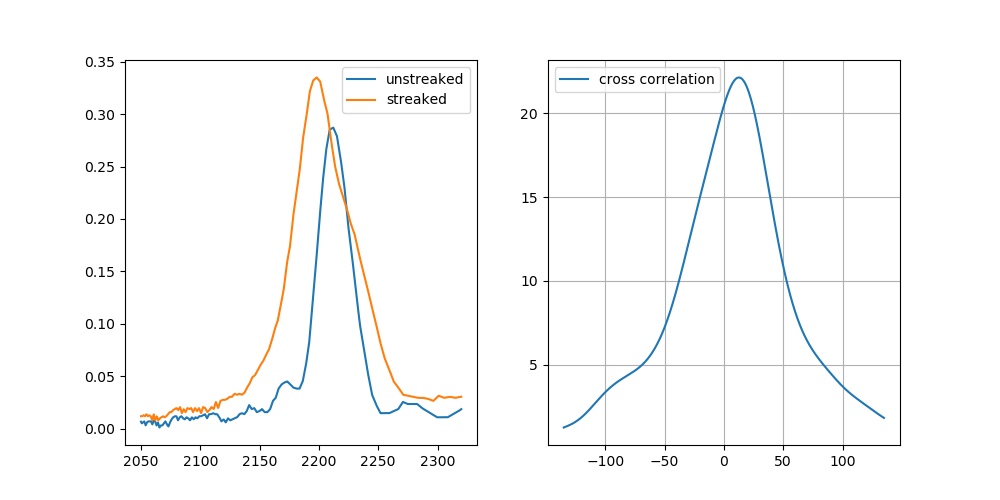

-57.909911473854066


In [12]:
# Check one shot (be careful, could be a dark one!!) to see the TOF peak and cross correlation

shot = 0  

plt.figure(figsize= (10,5))
plt.subplot(121)
plt.plot(palm.energy_range, input_data['0'][shot], label="unstreaked")
plt.plot(palm.energy_range, input_data['1'][shot], label="streaked")
plt.legend(loc="best")

plt.subplot(122)
plt.plot(lags, cross_corr[shot], label="cross correlation")
plt.legend(loc="best")
plt.grid()

print (delays[shot]*ev2fsCalib)



### Analyse a series of files

In [17]:
datalist = glob.glob(DIR + "*.BSREAD.h5")
datalist = sorted(datalist)
datalist

['/sf/alvra/data/p18389/raw/TD1_30ps_pump_dark/run_000553.BSREAD.h5',
 '/sf/alvra/data/p18389/raw/TD1_30ps_pump_dark/run_000554.BSREAD.h5',
 '/sf/alvra/data/p18389/raw/TD1_30ps_pump_dark/run_000555.BSREAD.h5',
 '/sf/alvra/data/p18389/raw/TD1_30ps_pump_dark/run_000556.BSREAD.h5',
 '/sf/alvra/data/p18389/raw/TD1_30ps_pump_dark/run_000557.BSREAD.h5',
 '/sf/alvra/data/p18389/raw/TD1_30ps_pump_dark/run_000558.BSREAD.h5',
 '/sf/alvra/data/p18389/raw/TD1_30ps_pump_dark/run_000559.BSREAD.h5',
 '/sf/alvra/data/p18389/raw/TD1_30ps_pump_dark/run_000560.BSREAD.h5',
 '/sf/alvra/data/p18389/raw/TD1_30ps_pump_dark/run_000561.BSREAD.h5',
 '/sf/alvra/data/p18389/raw/TD1_30ps_pump_dark/run_000562.BSREAD.h5',
 '/sf/alvra/data/p18389/raw/TD1_30ps_pump_dark/run_000563.BSREAD.h5',
 '/sf/alvra/data/p18389/raw/TD1_30ps_pump_dark/run_000564.BSREAD.h5',
 '/sf/alvra/data/p18389/raw/TD1_30ps_pump_dark/run_000565.BSREAD.h5',
 '/sf/alvra/data/p18389/raw/TD1_30ps_pump_dark/run_000566.BSREAD.h5',
 '/sf/alvra/data/p18

In [26]:
file[45:]

'run_000556.BSREAD.h5'

In [27]:
listfile = os.listdir(DIR)
number_files = len(listfile)

#ev2fsCalib= 20.723024835035712    # This is from THz scan_508

print ("Calibration factor is {} eV/fs".format(ev2fsCalib))

number_files = 1

delays_Dark_all = []
delays_Light_all = []
delays_mean = []
cross_corr_all = []
str_OK = []
ref_OK = []
pulseID_filter = []
pulseID_first = []
run_number = []

#start_index = 611
nshots = None

#for i in range(start_index,start_index + number_files):
for file in datalist:
    fileName = file #DIR + "run_000" + str(i) + ".BSREAD.h5"
 #   print (fileName)
    exists = os.path.isfile(fileName)
    if exists:
       # fileName = load_data._get_data(fileName)
        with h5py.File(fileName, 'r') as BS_file:
            data = load_data._get_data(BS_file)
            #print (data)
            FEL = data["SAR-CVME-TIFALL5:EvtSet/data"][:nshots,48]
            Laser = data["SAR-CVME-TIFALL5:EvtSet/data"][:nshots,18]
            Darkshot = data["SAR-CVME-TIFALL5:EvtSet/data"][:nshots,21]
        
        pulse_id, delays, _, (input_data, lags, cross_corr, _) = palm.process_hdf5_file(fileName, debug=True)
        delays_fs = delays * ev2fsCalib
        pulseID_first.append(pulse_id[0]) 
        run_number.append(i)
        print ("Processing file {}". format(fileName))
        
        reprate_light = np.logical_and.reduce((FEL, Laser, np.logical_not(Darkshot)))
        reprate_dark = np.logical_and.reduce((FEL, Laser, Darkshot))
           
        beamOK = (np.amax(input_data['0'],axis=1) > 0.1)# & (delays !=0.0)
        
        delays_beamOK_light = delays_fs[beamOK & reprate_light]
        delays_beamOK_dark = delays_fs[beamOK & reprate_dark]
        
        refData_OK = input_data['0'][beamOK & reprate_light]
        StrData_OK = input_data['1'][beamOK & reprate_light]
        cross_corr_OK = cross_corr[beamOK & reprate_light]
        pulseID_OK = pulse_id[beamOK & reprate_light]
        
        ref_OK.append(refData_OK)
        str_OK.append(StrData_OK)
               
        delays_Light_all.append(delays_beamOK_light)
        delays_Dark_all.append(delays_beamOK_dark)
        cross_corr_all.append(cross_corr_OK)
        pulseID_filter.append(pulseID_OK)
        
        delays_mean.append(np.mean(delays_beamOK_light))
               
        print ("Run {}, Pulse ID = {} ----- mean delay = {} fs".format(file[:45], pulse_id[0], np.round(np.mean(delays_beamOK_light),3)))#, fileName,"pulseID =",pulse_id[0],)
        
delays_Dark_all = np.asarray(delays_Dark_all)
delays_Light_all = np.asarray(delays_Light_all)
delays_mean = np.asarray(delays_mean)
cross_corr_all = np.asarray(cross_corr_all)
ref_OK = np.array(ref_OK)
str_OK = np.array(str_OK)
pulseID_filter = np.array(pulseID_filter)
#pulseID_first = np.array(pulseID_first)
print ("Job done!")

Calibration factor is -4.610191678065906 eV/fs
Processing file /sf/alvra/data/p18389/raw/TD1_30ps_pump_dark/run_000553.BSREAD.h5
Run /sf/alvra/data/p18389/raw/TD1_30ps_pump_dark/, Pulse ID = 11248095854 ----- mean delay = -76.835 fs
Processing file /sf/alvra/data/p18389/raw/TD1_30ps_pump_dark/run_000554.BSREAD.h5
Run /sf/alvra/data/p18389/raw/TD1_30ps_pump_dark/, Pulse ID = 11248106562 ----- mean delay = -79.848 fs
Processing file /sf/alvra/data/p18389/raw/TD1_30ps_pump_dark/run_000555.BSREAD.h5
Run /sf/alvra/data/p18389/raw/TD1_30ps_pump_dark/, Pulse ID = 11248117254 ----- mean delay = -86.872 fs
Processing file /sf/alvra/data/p18389/raw/TD1_30ps_pump_dark/run_000556.BSREAD.h5
Run /sf/alvra/data/p18389/raw/TD1_30ps_pump_dark/, Pulse ID = 11248127958 ----- mean delay = -111.5 fs
Processing file /sf/alvra/data/p18389/raw/TD1_30ps_pump_dark/run_000557.BSREAD.h5
Run /sf/alvra/data/p18389/raw/TD1_30ps_pump_dark/, Pulse ID = 11248138652 ----- mean delay = -124.214 fs
Processing file /sf/alv

/sf/alvra/anaconda/alvra-analysis/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/sf/alvra/anaconda/alvra-analysis/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Processing file /sf/alvra/data/p18389/raw/TD1_30ps_pump_dark/run_000563.BSREAD.h5
Run /sf/alvra/data/p18389/raw/TD1_30ps_pump_dark/, Pulse ID = 11248318700 ----- mean delay = -124.778 fs
Processing file /sf/alvra/data/p18389/raw/TD1_30ps_pump_dark/run_000564.BSREAD.h5
Run /sf/alvra/data/p18389/raw/TD1_30ps_pump_dark/, Pulse ID = 11248329580 ----- mean delay = -139.026 fs
Processing file /sf/alvra/data/p18389/raw/TD1_30ps_pump_dark/run_000565.BSREAD.h5
Run /sf/alvra/data/p18389/raw/TD1_30ps_pump_dark/, Pulse ID = 11248451540 ----- mean delay = -116.227 fs
Processing file /sf/alvra/data/p18389/raw/TD1_30ps_pump_dark/run_000566.BSREAD.h5
Run /sf/alvra/data/p18389/raw/TD1_30ps_pump_dark/, Pulse ID = 11248530052 ----- mean delay = -104.464 fs
Processing file /sf/alvra/data/p18389/raw/TD1_30ps_pump_dark/run_000567.BSREAD.h5
Run /sf/alvra/data/p18389/raw/TD1_30ps_pump_dark/, Pulse ID = 11248658552 ----- mean delay = -71.689 fs
Processing file /sf/alvra/data/p18389/raw/TD1_30ps_pump_dark/run_0

Processing file /sf/alvra/data/p18389/raw/TD1_30ps_pump_dark/run_000607.BSREAD.h5
Run /sf/alvra/data/p18389/raw/TD1_30ps_pump_dark/, Pulse ID = 11249365304 ----- mean delay = -215.796 fs
Processing file /sf/alvra/data/p18389/raw/TD1_30ps_pump_dark/run_000608.BSREAD.h5
Run /sf/alvra/data/p18389/raw/TD1_30ps_pump_dark/, Pulse ID = 11249376016 ----- mean delay = -217.086 fs
Processing file /sf/alvra/data/p18389/raw/TD1_30ps_pump_dark/run_000609.BSREAD.h5
Run /sf/alvra/data/p18389/raw/TD1_30ps_pump_dark/, Pulse ID = 11249386914 ----- mean delay = -204.689 fs
Processing file /sf/alvra/data/p18389/raw/TD1_30ps_pump_dark/run_000610.BSREAD.h5
Run /sf/alvra/data/p18389/raw/TD1_30ps_pump_dark/, Pulse ID = 11249397822 ----- mean delay = -200.542 fs
Processing file /sf/alvra/data/p18389/raw/TD1_30ps_pump_dark/run_000611.BSREAD.h5
Run /sf/alvra/data/p18389/raw/TD1_30ps_pump_dark/, Pulse ID = 11249408522 ----- mean delay = -189.559 fs
Processing file /sf/alvra/data/p18389/raw/TD1_30ps_pump_dark/run_

Processing file /sf/alvra/data/p18389/raw/TD1_30ps_pump_dark/run_000651.BSREAD.h5
Run /sf/alvra/data/p18389/raw/TD1_30ps_pump_dark/, Pulse ID = 11250342260 ----- mean delay = -339.365 fs
Processing file /sf/alvra/data/p18389/raw/TD1_30ps_pump_dark/run_000652.BSREAD.h5
Run /sf/alvra/data/p18389/raw/TD1_30ps_pump_dark/, Pulse ID = 11250352962 ----- mean delay = -231.328 fs
Processing file /sf/alvra/data/p18389/raw/TD1_30ps_pump_dark/run_000653.BSREAD.h5
Run /sf/alvra/data/p18389/raw/TD1_30ps_pump_dark/, Pulse ID = 11250363662 ----- mean delay = -255.769 fs
Processing file /sf/alvra/data/p18389/raw/TD1_30ps_pump_dark/run_000654.BSREAD.h5
Run /sf/alvra/data/p18389/raw/TD1_30ps_pump_dark/, Pulse ID = 11250374370 ----- mean delay = nan fs
Processing file /sf/alvra/data/p18389/raw/TD1_30ps_pump_dark/run_000655.BSREAD.h5
Run /sf/alvra/data/p18389/raw/TD1_30ps_pump_dark/, Pulse ID = 11250385078 ----- mean delay = nan fs
Processing file /sf/alvra/data/p18389/raw/TD1_30ps_pump_dark/run_000656.BSR

In [97]:
delays_mean.shape

AttributeError: 'list' object has no attribute 'shape'

<IPython.core.display.Javascript object>


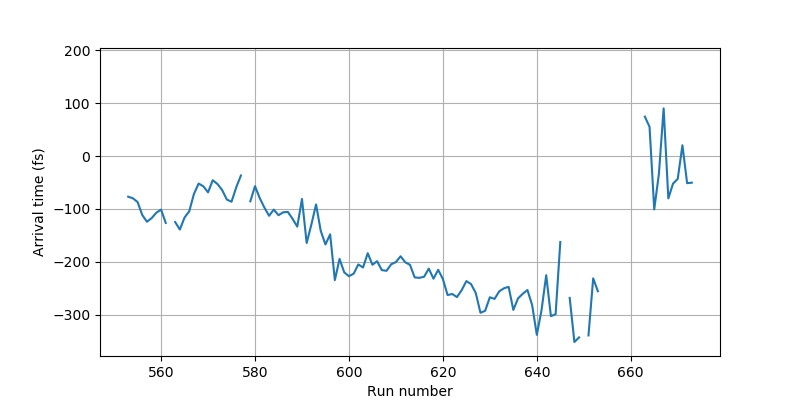

In [31]:
xaxis = np.linspace(553, 692, (692 - 553)+1)

plt.figure(figsize=(8,4))
plt.plot(xaxis, delays_mean, label = 'mean arrival time')
plt.ylabel('Arrival time (fs)')
plt.xlabel('Run number')
plt.grid()

plt.show()

In [52]:
Total_light_1D = np.hstack(delays_Light_all)
print (Total_light_1D.shape)

Total_pulseIDS = np.hstack(pulseID_filter)
print (Total_pulseIDS.shape)

Total_strData = np.vstack(str_OK)
Total_refData = np.vstack(ref_OK)
print (Total_strData.shape)

Total_corrData = np.vstack(cross_corr_all)
print (Total_corrData.shape)

(2454,)
(2454,)
(2454, 2000)
(2454, 2000)


<>:6: DeprecationWarning: invalid escape sequence \s
<>:6: DeprecationWarning: invalid escape sequence \s
<>:6: DeprecationWarning: invalid escape sequence \s
<ipython-input-64-dc0fc91f2c79>:6: DeprecationWarning: invalid escape sequence \s
  label= '$\sigma={}$ fs, mean={} fs'.format(np.round(Total_light_1D.std(),2),np.round(Total_light_1D.mean(),2)), alpha=0.5)


<IPython.core.display.Javascript object>


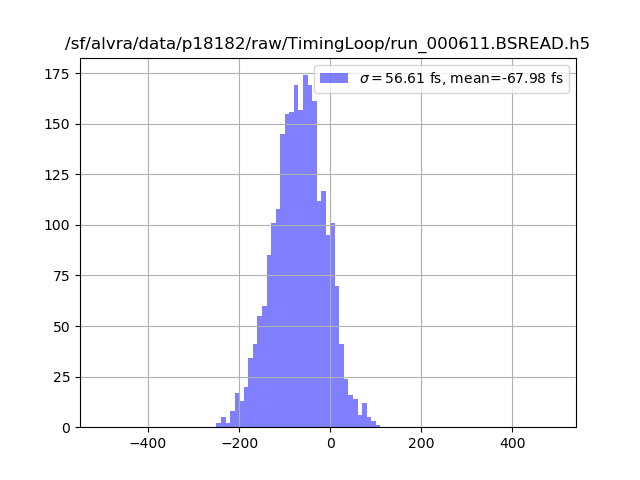

56.612871728278186
-67.97831903737222


In [64]:
num_bins =125
plt.figure()

#plt.hist(Total_light_1D, bins =np.arange(-500,500,10), facecolor='blue', label= r'$\sigma=%d$ fs' %Total_light_1D.std(), alpha=0.5)
plt.hist(Total_light_1D, bins =np.arange(-500,500,10), facecolor='blue', \
         label= '$\sigma={}$ fs, mean={} fs'.format(np.round(Total_light_1D.std(),2),np.round(Total_light_1D.mean(),2)), alpha=0.5)


plt.title(fileName)
plt.legend(loc='upper right')
#plt.text(-300,130,'Mean=%d'%Total_light_1D.mean())
plt.grid()

print (Total_light_1D.std())
print (Total_light_1D.mean())

plt.show()

In [ ]:
saveDir = "/das/work/p17/p17569/alvra_beamline_scripts/ProcessedData/"    # dest folder (needs to exist)
fn = str(saveDir + "Runs_451_513.h5")

hf = h5py.File(fn, 'w')
hf.create_dataset('Total_light_1D', data=Total_light_1D)
hf.create_dataset('Total_pulseIDS', data=Total_pulseIDS)
hf.create_dataset('Total_strData', data=Total_strData)
hf.create_dataset('Total_refData', data=Total_refData)
hf.create_dataset('Total_corrData', data=Total_corrData)
hf.close()

In [38]:
itemindex = np.where(Total_light_1D==66.05130091)

In [39]:
import pandas as pd
#input_data_max = np.amax(input_data['0'],axis=1)
df = pd.DataFrame(Total_light_1D)
Avg = df.rolling(300).mean()

<IPython.core.display.Javascript object>


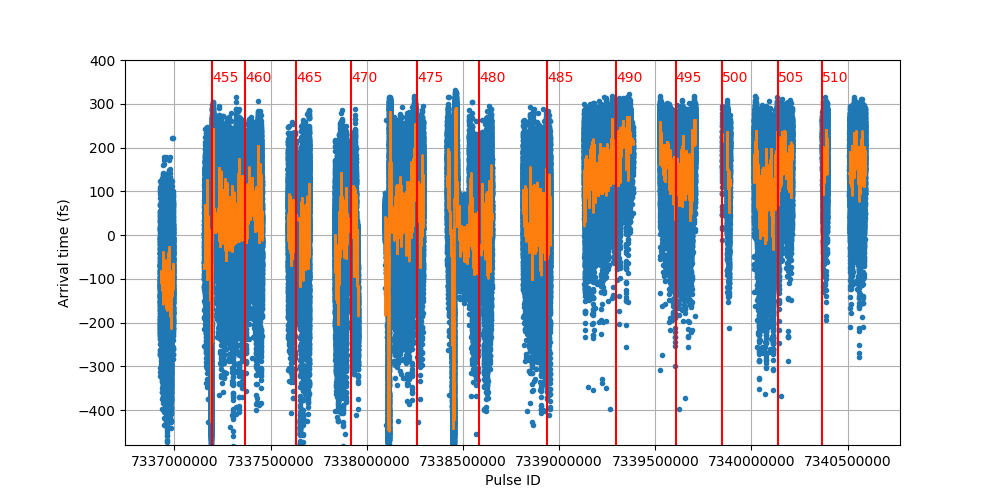

In [40]:
plt.figure(figsize= (10,5))
#plt.plot(Total_light_1D[0::1000])
plt.plot(Total_pulseIDS, Total_light_1D[:],'.')
#plt.plot(Total_light_1D[:],'.')

plt.plot(Total_pulseIDS, Avg,'.', ms=1 )


for xc in pulseID_first:
    if run_number[pulseID_first.index(xc)]%5 ==0:
        plt.axvline(x=xc, color = 'r')
        #plt.text(xc,200, pulseID_first.index(xc)+start_index,color = 'r')
        plt.text(xc,350, run_number[pulseID_first.index(xc)],color = 'r')

plt.ylabel("Arrival time (fs)")
#plt.xlabel("shot number")
plt.xlabel("Pulse ID")

plt.ticklabel_format(useOffset=False, style='plain')
plt.ylim((-480,400))
plt.grid()


<IPython.core.display.Javascript object>


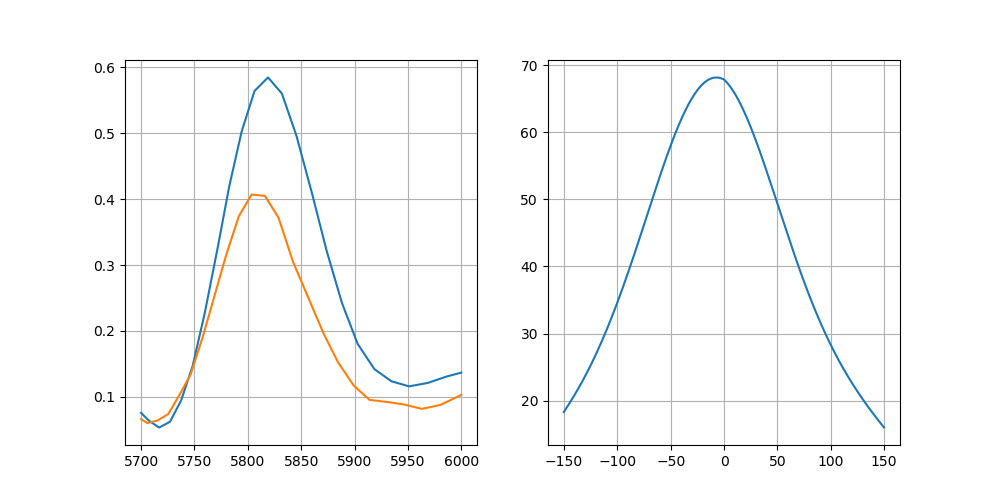

IndexError: index 450000 is out of bounds for axis 0 with size 39997

In [45]:
shot = 450000
plt.figure(figsize= (10,5))


plt.subplot(121)
plt.plot(palm.energy_range, Total_strData[shot])
plt.plot(palm.energy_range, Total_refData[shot])
plt.grid()

plt.subplot(122)
plt.plot(lags, Total_corrData[shot])
plt.grid()

plt.show()
print ("pulseID=",pulse_id[shot],"delay=",Total_strData[shot])

In [208]:
len(input_data['0'][input_data_max > 0.1])

6953

In [ ]:
pulse_id, delays, _, (input_data, lags, cross_corr, _) = res

8041925336


<IPython.core.display.Javascript object>


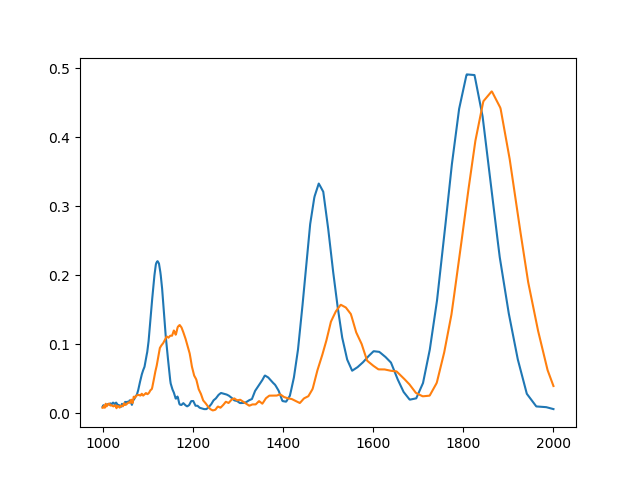

In [11]:
# Plot converted input data (eTOF time bins -> energy)
shot = 2
print (pulse_id[shot])
plt.figure()
plt.plot(palm.energy_range, input_data['0'][shot])
plt.plot(palm.energy_range, input_data['1'][shot])


In [7]:
cross_corr.shape

(39997, 1000)

<IPython.core.display.Javascript object>


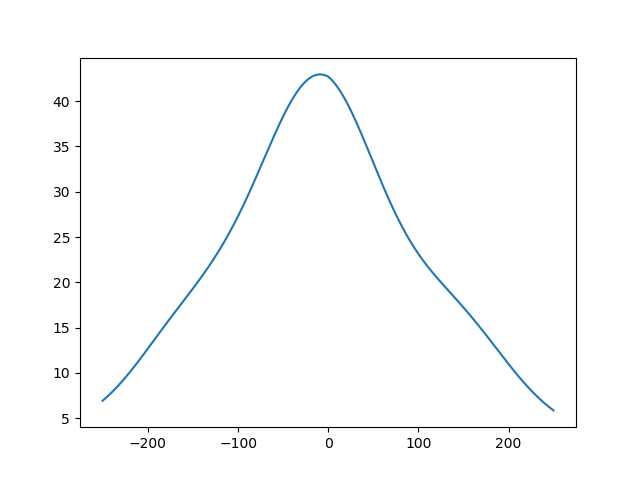

-9.009009009008878


In [168]:
# Plot cross-correlation results
plt.figure()
plt.plot(lags, cross_corr[shot])
print (delays[shot])

In [121]:
delays[6101]

-250.25025025025025

In [57]:
reprate_dark = pulse_id%20 == 0
reprate_light = ((pulse_id%4 == 0) & (pulse_id%20 != 0))
reprate_FEL = pulse_id%4 == 0

pulse_ids_light = pulse_id[reprate_light]
pulse_ids_dark = pulse_id[reprate_dark]

delays_light = delays[reprate_light]
delays_dark = delays[reprate_dark]

In [58]:
print (pulse_id.shape)
print (pulse_ids_light.shape)
print (pulse_ids_dark.shape)

(39997,)
(8000,)
(2000,)


<IPython.core.display.Javascript object>


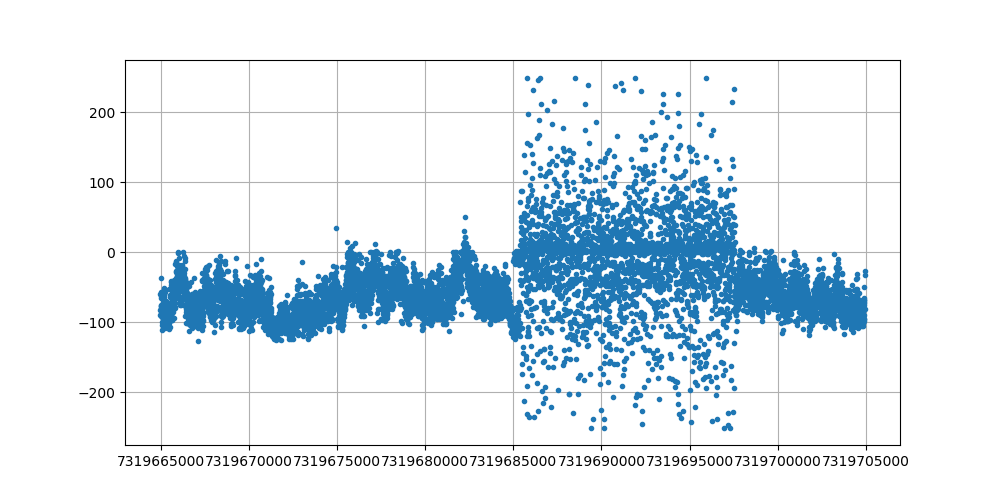

In [59]:
plt.figure(figsize= (10,5))
plt.plot(pulse_ids_light, delays_light, '.')

plt.ticklabel_format(useOffset=False, style='plain')
plt.grid()

<IPython.core.display.Javascript object>


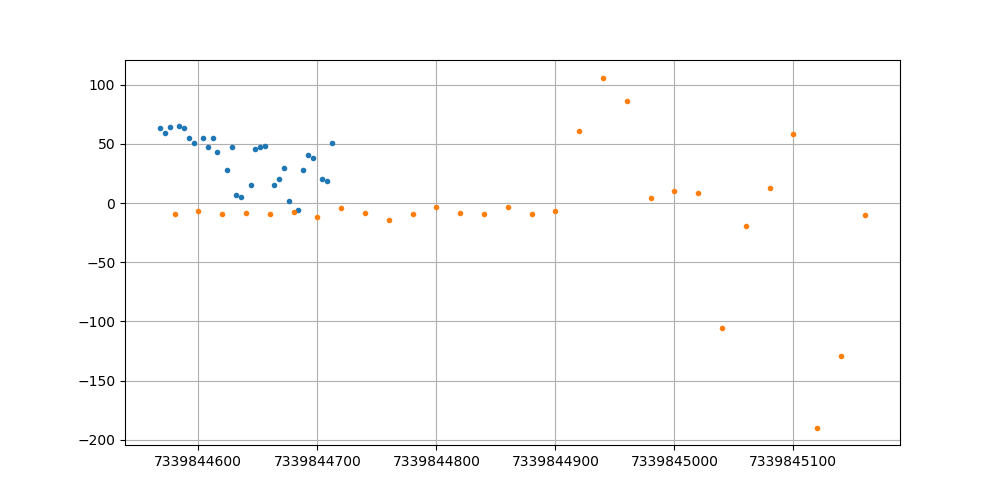

In [142]:
plt.figure(figsize= (10,5))
plt.plot(pulse_ids_light[0:30], delays_light[0:30], '.')
plt.plot(pulse_ids_dark[0:30], delays_dark[0:30], '.')

plt.ticklabel_format(useOffset=False, style='plain')
plt.grid()
#ind_good = pulse_id%..

In [163]:
print (delays_light.mean(), delays_light.std())

5.4278028028028045 77.2191535138822


In [61]:
513 - 450

63